## Running PERMANOVA Test

In [3]:
import sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import permanova, DistanceMatrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skbio.stats.distance import permdisp


sys.path.append("../file_loader")
sys.path.append("../preprocessing-block")
sys.path.append("../features_calculation")
sys.path.append("../statistical_tests")


import ecg_file_loader
from ecg_file_loader import ECGFileLoader

import rpeaks_finder
from rpeaks_finder import *

import ectopic_beats_filtering
from ectopic_beats_filtering import *

import time_features
from time_features import *

import frequency_features
from frequency_features import *

import nonlinear_features
from nonlinear_features import *


reload(ecg_file_loader)
reload(rpeaks_finder)
reload(ectopic_beats_filtering)
reload(time_features)
reload(frequency_features)
reload(nonlinear_features)

<module 'nonlinear_features' from '/Users/ashleyandrea/Documents/StartUps/seizury/seizure-block-codes/statistical_tests/../features_calculation/nonlinear_features.py'>

In [32]:
giorgio = pd.read_csv("giorgio.csv")

In [33]:
giorgio.drop(columns=["tm_sdnn_index", "tm_sdann"], inplace=True)

In [34]:
giorgio

,tm_nni_counter,tm_nni_mean,tm_nni_min,tm_nni_max,tm_hr_mean,tm_hr_min,tm_hr_max,tm_hr_std,tm_nni_diff_mean,tm_nni_diff_min,tm_nni_diff_max,tm_sdnn,tm_rmssd,tm_sdsd,tm_nn50,tm_pnn50,tm_nn20,tm_pnn20,tm_tinn_n,tm_tinn_m,tm_tinn,tm_tri_index,nl_sd1,nl_sd2,nl_sd_ratio,nl_ellipse_area,nl_sampen,nl_dfa_alpha1,nl_dfa_alpha2,group
0,346.0,863.482659,746.0,953.0,69.598882,62.959077,80.428954,2.856216,22.594203,0.0,70.0,34.288731,27.138240,15.054667,19.0,5.507246,169.0,48.985507,804.6875,921.8750,117.1875,8.238095,19.189628,44.517524,2.319874,2683.783227,1.874647,0.883417,1.439776,non_seizure
1,345.0,866.260870,746.0,953.0,69.381656,62.959077,80.428954,2.927492,24.043605,0.0,66.0,35.232885,28.711425,15.715245,22.0,6.395349,181.0,52.616279,812.5000,937.5000,125.0000,8.625000,20.301943,45.487825,2.240565,2901.233326,1.793765,0.993962,1.530520,non_seizure
2,344.0,869.139535,746.0,953.0,69.164264,62.959077,80.428954,3.071315,25.367347,0.0,66.0,37.108512,29.969518,15.981689,25.0,7.288630,189.0,55.102041,804.6875,929.6875,125.0000,8.190476,21.191576,47.998009,2.264957,3195.481848,1.811984,1.030173,1.462778,non_seizure
3,342.0,873.663743,746.0,953.0,68.806972,62.959077,80.428954,3.077278,26.366569,0.0,74.0,37.289402,31.123206,16.560866,31.0,9.090909,200.0,58.651026,820.3125,937.5000,117.1875,7.953488,22.007249,47.890155,2.176108,3311.020574,1.795696,0.859805,1.352540,non_seizure
4,341.0,876.111437,746.0,945.0,68.607051,63.492063,80.428954,2.989288,26.858824,0.0,74.0,36.124937,31.376368,16.243649,28.0,8.235294,210.0,61.764706,828.1250,937.5000,109.3750,7.104167,22.186236,45.965033,2.071781,3203.768181,1.714617,0.865781,0.852015,non_seizure
5,339.0,882.805310,812.0,945.0,68.020629,63.492063,73.891626,1.952372,28.443787,0.0,74.0,25.177192,32.777265,16.312184,32.0,9.467456,219.0,64.792899,828.1250,937.5000,109.3750,6.647059,23.177025,26.836762,1.157904,1954.059036,1.769287,0.447007,1.154363,non_seizure
6,339.0,880.952802,812.0,945.0,68.163763,63.492063,73.891626,1.957371,28.168639,0.0,74.0,25.156507,32.388041,16.008472,31.0,9.171598,217.0,64.201183,828.1250,929.6875,101.5625,6.519231,22.901627,27.172674,1.186495,1955.008182,1.768030,0.411552,0.772403,non_seizure
7,340.0,880.326471,828.0,941.0,68.202189,63.761955,72.463768,1.764781,28.088496,0.0,74.0,22.853049,32.269057,15.908331,29.0,8.554572,219.0,64.601770,828.1250,921.8750,93.7500,6.181818,22.817655,22.881989,1.002819,1640.267407,1.800750,0.352996,0.931003,non_seizure
8,341.0,876.882698,828.0,941.0,68.469580,63.761955,72.463768,1.762805,27.052941,0.0,71.0,22.648939,31.177669,15.520758,25.0,7.352941,211.0,62.058824,820.3125,921.8750,101.5625,5.779661,22.045940,23.227898,1.053613,1608.749375,1.734601,0.393682,1.054298,non_seizure
9,341.0,876.322581,828.0,953.0,68.518367,62.959077,72.463768,1.851980,28.823529,0.0,71.0,23.948015,33.508647,17.114176,41.0,12.058824,214.0,62.941176,820.3125,914.0625,93.7500,5.683333,23.693884,24.066637,1.015732,1791.437010,1.653113,0.417894,1.078689,non_seizure


#### Rescaling features to contribute equally to the distance

In [35]:
scaler = StandardScaler()

X = giorgio.drop(columns=['group']).values
X_scaled = scaler.fit_transform(X)  
N = X_scaled.shape[0]
n_groups = giorgio['group'].nunique()

print(f"Number of samples: {N}")
print(f"Number of groups: {n_groups}")

Number of samples: 40
Number of groups: 2


#### Computing distance matrix and running PERMANOVA globally

Using different distance types to ensure robustness.

Results should be displayed in the form: 
```
method name               PERMANOVA
test statistic name        pseudo-F
sample size                 40
number of groups            2
test statistic              4.23
p-value                     0.001
number of permutations      999
Name: PERMANOVA results, dtype: object
```

How do permutations influence significance (p-value)? 
If **p < 0.05**, that means the observed separation between groups (pre-seizure vs. non-seizure) is unlikely to have occurred by chance under the null hypothesis (that all samples come from the same population). **There is a statistically significant multivariate difference between the groups.**

Also, **pseudo-F value**: ratio of between-group variance to within-group variance. **Higher pseudo-F ⇒ greater separation between group centroids** relative to internal spread. Not universal value, to interpret relative to different feature sets.

**R²** expresses the fraction of total variance explained by group differences (e.g. R² = 0.25 → group membership explains 25 % of overall variation). **We want a high R²**.

PERMANOVA assumes the two groups differ in centroid, not just spread. If one group is simply more variable, it can inflate pseudo-F and yield a small p-value -> PERMDISP (homogeneity of dispersion test):

- **Non-significant dispersion test (p > 0.05)** → differences likely due to centroid shift (true effect).
- **Significant dispersion test (p < 0.05)** → groups might just differ in variability.

In [37]:
for metric in ["euclidean", "cityblock", "cosine", "mahalanobis"]:
    try:
        if metric == "cityblock":
            # cityblock is the correct name for Manhattan distance
            dist_matrix = squareform(pdist(X_scaled, metric='cityblock'))
        elif metric == "mahalanobis":
            # Mahalanobis needs covariance matrix
            cov = np.cov(X_scaled, rowvar=False)
            eps = 1e-8
            cov_reg = cov + np.eye(cov.shape[0]) * eps
            try:
                VI = np.linalg.inv(cov_reg)
            except np.linalg.LinAlgError:
                VI = np.linalg.pinv(cov_reg)
            dist_matrix = squareform(pdist(X_scaled, metric='mahalanobis', VI=VI))
        elif metric == "cosine":
            X_norm = normalize(X_scaled, norm='l2')
            dist_matrix = squareform(pdist(X_norm, metric='cosine'))
        else:
            dist_matrix = squareform(pdist(X_scaled, metric=metric))
        
        # Create simple sequential IDs that match the number of rows
        sample_ids = [str(i) for i in range(len(X_scaled))]
        dm = DistanceMatrix(dist_matrix, ids=sample_ids)
        
        # Extract group labels as a LIST (not pandas Series)
        group_labels = giorgio['group'].tolist()
        
        # Run PERMANOVA with the group list
        result = permanova(dm, group_labels, permutations=999)
        
        # Calculate R²
        df_between = n_groups - 1
        df_within = N - n_groups
        pseudo_F = result['test statistic']
        R2 = (pseudo_F * df_between) / (pseudo_F * df_between + df_within)
        
        # Run PERMDISP
        disp_result = permdisp(dm, group_labels, permutations=999)
        
        print(f"=== Metric: {metric} ===")
        print(f"  pseudo-F: {result['test statistic']:.4f}")
        print(f"  p-value: {result['p-value']:.4f}")
        print(f"  R²: {R2:.4f}")
        print(f"  PERMDISP p-value: {disp_result['p-value']:.4f}")
        print()
        
    except Exception as e:
        print(f"Metric {metric} failed: {e}")
        import traceback
        traceback.print_exc()
        print()

=== Metric: euclidean ===
  pseudo-F: 15.1182
  p-value: 0.0010
  R²: 0.2846
  PERMDISP p-value: 0.0010

=== Metric: cityblock ===
  pseudo-F: 17.6106
  p-value: 0.0010
  R²: 0.3167
  PERMDISP p-value: 0.0020

=== Metric: cosine ===
  pseudo-F: 48.6424
  p-value: 0.0010
  R²: 0.5614
  PERMDISP p-value: 0.0010

=== Metric: mahalanobis ===
  pseudo-F: 1.5140
  p-value: 0.0010
  R²: 0.0383
  PERMDISP p-value: 0.0040



#### PCA for visual group separation

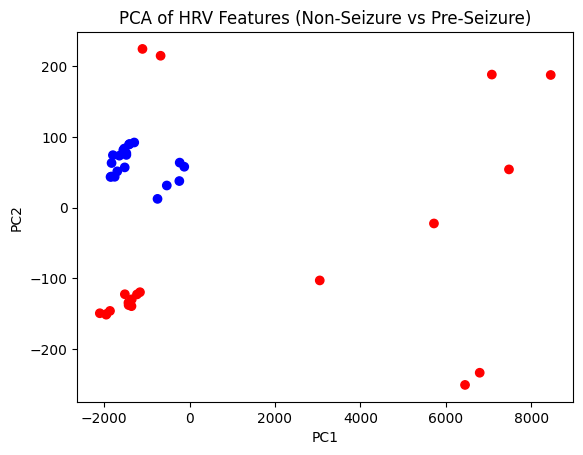

In [38]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.scatter(components[:, 0], components[:, 1], c=giorgio['group'].map({'non_seizure': 'blue', 'pre_seizure': 'red'}))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of HRV Features (Non-Seizure vs Pre-Seizure)")
plt.show()

#### Running PERMANOVA on different sets of features for domain-specific analysis

In [39]:
# Time-domain subset
time_features = ["tm_nni_counter", "tm_nni_mean", "tm_nni_min", "tm_nni_max", "tm_hr_mean", "tm_hr_min", "tm_hr_max", "tm_hr_std", "tm_nni_diff_mean", "tm_nni_diff_min", "tm_nni_diff_max", "tm_sdnn", "tm_sdnn_index", "tm_sdann", "tm_rmssd", "tm_sdsd", "tm_nn50", "tm_pnn50", "tm_nn20", "tm_pnn20", "tm_nni_histogram", "tm_tinn_n", "tm_tinn_m", "tm_tinn", "tm_tri_index"]

# Frequency LF+HF subset
lf_hf_features = ["ft_lf_abs", "ft_lf_rel", "ft_lf_peak", "ft_hf_abs", "ft_hf_rel", "ft_hf_peak", "ft_lf_hf_ratio", "ft_fft_rel_lf", "ft_fft_rel_hf", "ft_total_power"]

# Frequency VLF subset
vlf_features = ["ft_vlf_abs", "ft_vlf_rel", "ft_vlf_peak", "ft_total_power"]

# Nonlinear subset
nonlinear_features = ["nl_sd1", "nl_sd2", "nl_sd1_sd2_ratio", "nl_ellipse_area", "nl_sampen", "nl_dfa_alpha1", "nl_dfa_alpha2", "nl_dfa_alpha1_beats", "nl_dfa_alpha2_beats"]

In [ ]:
# Adjust!!
for subset_name, subset_features in {
    "Time": time_features,
    "Frequency LF+HF": lf_hf_features,
    "Frequency VLF": vlf_features,
    "Nonlinear": nonlinear_features
}.items():
    X_sub = giorgio[subset_features]
    X_scaled = StandardScaler().fit_transform(X_sub)
    dist_matrix = squareform(pdist(X_scaled, metric="euclidean"))  # choose distance with most significant result globally
    dm = DistanceMatrix(dist_matrix, ids=giorgio.index.astype(str))
    res = permanova(dm, giorgio["group"], permutations=999)
    print(subset_name, "→ p =", res['p-value'])